In [92]:
import pandas as pd
from author_properties_transformers import author_influence



from datetime import timezone, datetime
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score

import xgboost as xgb

from sklearn.preprocessing import FunctionTransformer
import seaborn as sns

In [80]:
df = pd.read_csv("../Data/wsb_full_not_deleted_withdt.csv")

df = df.loc[df.author != "None"]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (45,88,117,118,119,122,123,124,125) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [81]:

df ["created_datetime_utc"] = df["created_utc"].apply(datetime.utcfromtimestamp)
df['weektime'] = df['created_datetime_utc'].apply( lambda x : x.weekday()*24 + x.hour)
df['time_of_day'] = df['created_datetime_utc'].apply( lambda x : x.hour)

In [82]:
df_cleaned = df[ [  'id', 'title', 'author', 'ups', 'weektime', 'time_of_day', 'selftext']]

In [83]:
author_stat_features = FeatureUnion([('aggsum', author_influence(kind = 'sum')), 
                           ('aggmean', author_influence(kind = 'mean')), 
                           ('aggmedian', author_influence(kind = 'median')),
                            ('aggcount', author_influence(kind = 'count'))
                           
                           ])
# testing:
# todo: make sure that nothing gets modified inplace that shouldnt be...
# author_stat_features
# author_stat_features.fit(df)
# pd.DataFrame(author_stat_features.transform(df))


In [84]:

time_features = make_union( make_column_transformer(  (FunctionTransformer(lambda x : x), ["weektime", "time_of_day"] ),
                                                   )            
                          )

#time_features.fit_transform(df_cleaned)


In [ ]:
nlp_features = FeatureUnion([
    
    
    
    
])

In [85]:


all_features = make_union ( author_stat_features, time_features )

<AxesSubplot:ylabel='ups'>

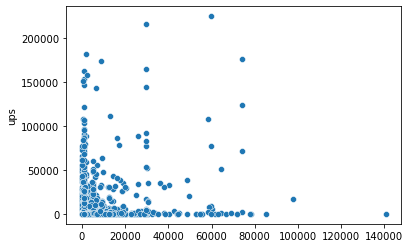

In [87]:


X_train, X_test, y_train, y_test = train_test_split(df_cleaned, df_cleaned.ups,
                                                    random_state=0)


lr = LinearRegression()

pipe = make_pipeline(all_features, lr)
pipe.fit(X_train, y_train)

pipe.predict(X_test)

sns.scatterplot(x = pipe.predict(X_test), y = y_test)

<AxesSubplot:ylabel='ups'>

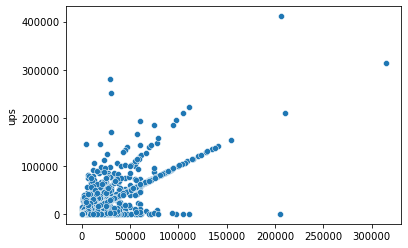

In [88]:
sns.scatterplot(x = pipe.predict(X_train), y = y_train)

In [89]:

scores = cross_val_score(pipe, df_cleaned, df_cleaned.ups)

In [90]:
scores

array([-3.28277545, -2.70359793, -1.42018051,  0.02421643, -0.08948711])

<AxesSubplot:ylabel='ups'>

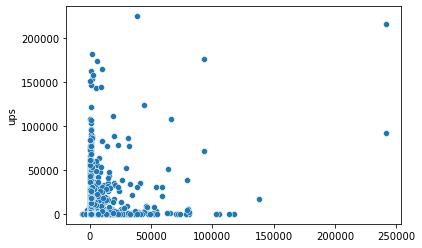

In [93]:





X_train, X_test, y_train, y_test = train_test_split(df_cleaned, df_cleaned.ups,
                                                    random_state=0)


xgr = xgb.XGBRegressor(random_state=2)

pipe = make_pipeline(all_features, xgr)
pipe.fit(X_train, y_train)

pipe.predict(X_test)

sns.scatterplot(x = pipe.predict(X_test), y = y_test)

In [ ]:
sns.scatterplot(x = pipe.predict(X_train), y = y_train)